In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 14c

## Tensor Flow
-  One hidden layer 
- ${ReLU}$ activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- BN
- Dropout
- save model
</p><img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [1]:
# TensorFlow
import tensorflow as tf

# Helper libraries
import os

import sys

from time import time

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

print(tf.__version__)

2023-11-27 18:08:02.429706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 18:08:02.429786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 18:08:02.432807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 18:08:02.447654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 18:08:03.327510: W tensorflow/compiler/tf2

2.15.0


In [2]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'fashion_MNIST' # location of the images
modelDir = '../models'
altName = 'dropout_bn_swish_fashion'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 10 # number of cycles to run
ALPHA = 0.1 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [3]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [4]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [5]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [7]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

## Whats in the data?

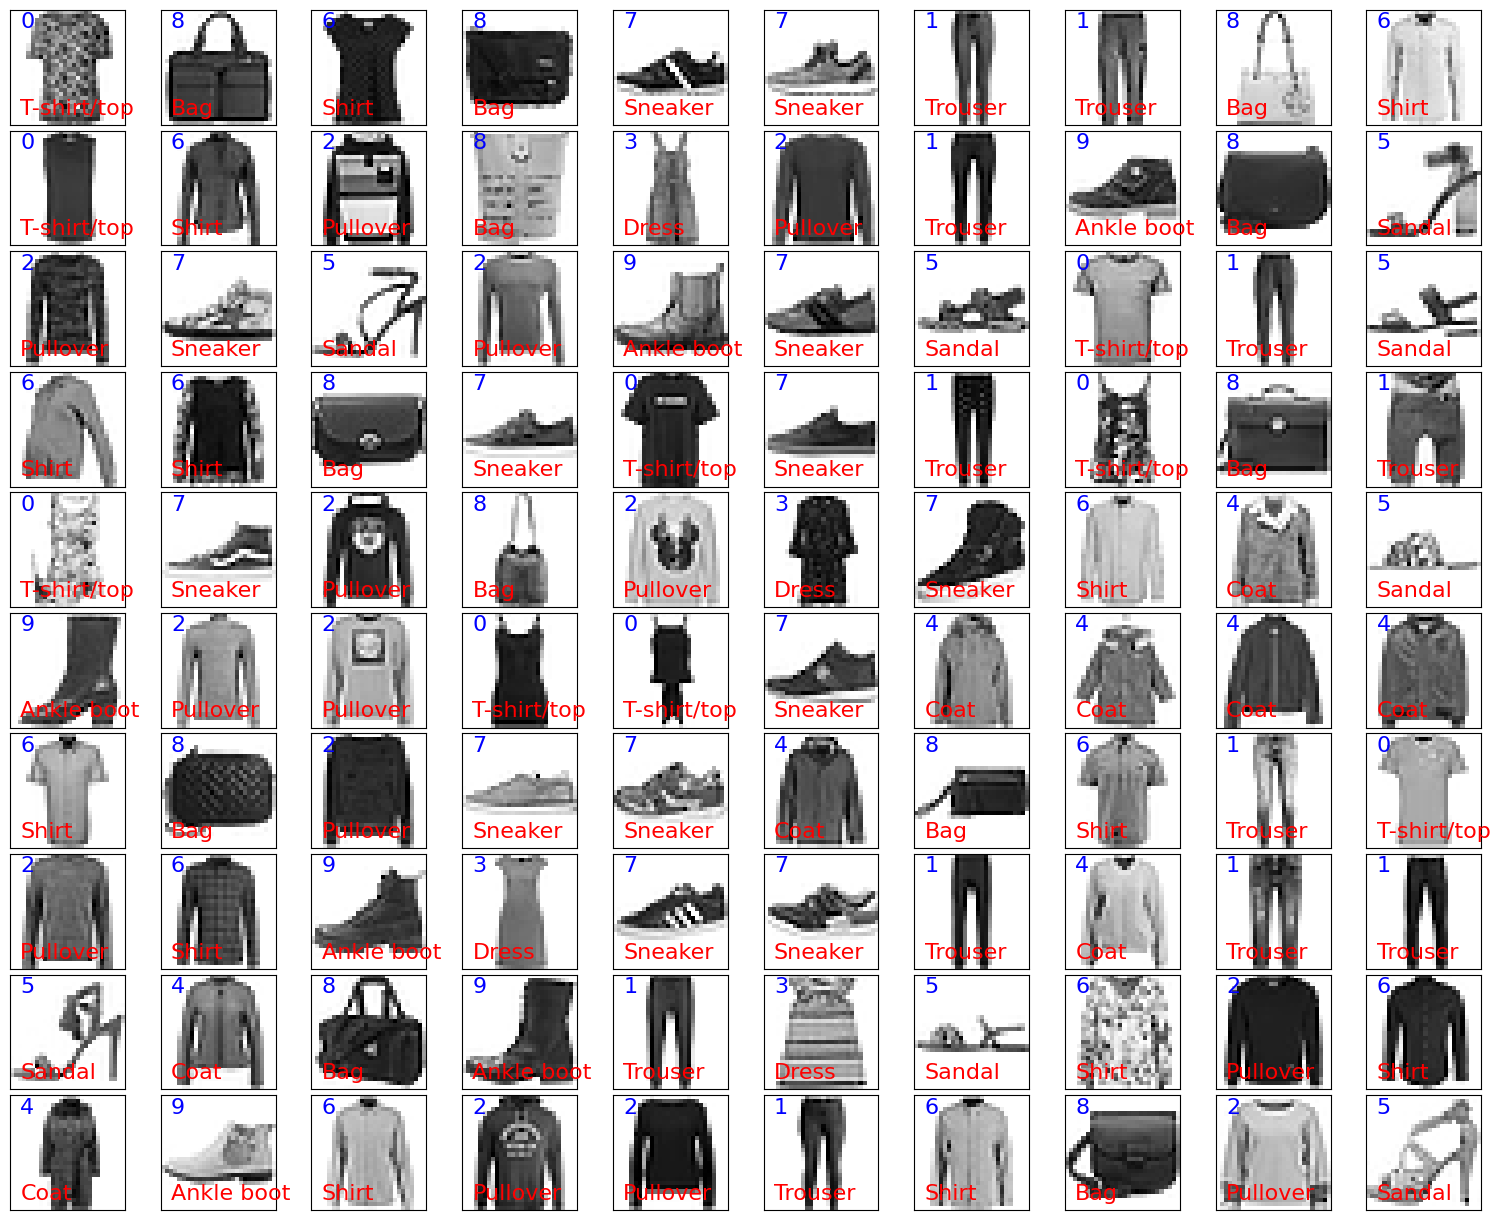

In [13]:
# Sample data plot

plot_df = train_df.sample(n = 100) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 12))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(10, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=16)   # add number (class) of the image
    
    ax.text(2, 25, class_names[row.iloc[0]], color='r', fontsize=16)   # add name of the image
    
plt.show()

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [14]:
X_train = train_df.drop('label', axis = 1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis = 1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [15]:
X_train = X_train / 255.0

X_test = X_test / 255.0

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

In [16]:
def build_model():
    dor1 = 0.10
    dor2 = 0.15
    
    model = tf.keras.Sequential([
        
        tf.keras.layers.Dense(784//4),
        
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(dor1), #  output_shape = 94, 94, 64
        
        tf.keras.layers.Dense(784//16),
        
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dropout(dor2), #  output_shape = 94, 94, 64
        
        tf.keras.layers.Dense(10)
    ])
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

In [17]:
# Create a basic model instance
model = build_model()

2023-11-27 18:10:23.954061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 18:10:23.991441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 18:10:23.991745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Train the model


First define call backs

In [18]:
checkpoint_dir = os.path.join(modelDir, subDir)

checkpoint_prefix = os.path.join(checkpoint_dir, altName)

model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                    monitor='val_loss',
                                                    mode='auto',
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    verbose=1)

In [19]:
model.fit(X_train, y_train, 
          validation_data=[X_test, y_test],
          epochs=10,
         callbacks=[model_callback])

Epoch 1/10


2023-11-27 18:10:51.775925: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-27 18:10:52.778860: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f378a3368b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 18:10:52.778899: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-27 18:10:52.782986: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 18:10:52.797631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1701088852.854421   11042 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1861/1875 [============================>.] - ETA: 0s - loss: 0.5296 - accuracy: 0.8158
Epoch 1: val_loss improved from inf to 0.41314, saving model to ../models/fashion_MNIST/dropout_bn_swish_fashion
1875/1875 [==============================] - 10s 4ms/step - loss: 0.5289 - accuracy: 0.8160 - val_loss: 0.4131 - val_accuracy: 0.8440
Epoch 2/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.4070 - accuracy: 0.8535
Epoch 2: val_loss improved from 0.41314 to 0.34951, saving model to ../models/fashion_MNIST/dropout_bn_swish_fashion
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4069 - accuracy: 0.8536 - val_loss: 0.3495 - val_accuracy: 0.8729
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.3679 - accuracy: 0.8660
Epoch 3: val_loss improved from 0.34951 to 0.32326, saving model to ../models/fashion_MNIST/dropout_bn_swish_fashion
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3680 - accuracy: 0.8660 - val_loss: 

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 196)               153860    
                                                                 
 batch_normalization (Batch  (None, 196)               784       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 196)               0         
                                                                 
 dropout (Dropout)           (None, 196)               0         
                                                                 
 dense_1 (Dense)             (None, 49)                9653      
                                                                 
 batch_normalization_1 (Bat  (None, 49)                196       
 chNormalization)                                       

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [20]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.3075 - accuracy: 0.8858 - 466ms/epoch - 1ms/step

Test accuracy: 0.8858000040054321


### Make predictions

In [21]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [22]:
predictions = probability_model.predict(X_test)

313/313 [==============================] - 0s 1ms/step


Plot to look at the full set of 10 class predictions.

In [24]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'../models/fashion_MNIST/dropout_bn_swish_fashion'

In [25]:
# Create a new model instance
model1 = build_model()

# Load the previously saved weights
model1.load_weights(latest)

# Re-evaluate the model
loss, acc = model1.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

313/313 - 1s - loss: 0.2975 - accuracy: 0.8932 - 629ms/epoch - 2ms/step
Restored model, accuracy: 89.32%
